In [7]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances

Read data

In [8]:
data = pd.read_csv('countries.csv')

1. Dựa vào dữ liệu sau, hiển thị tọa độ của theo lat và lon của các nước lên một bản đồ

In [9]:
df1 = data.copy()

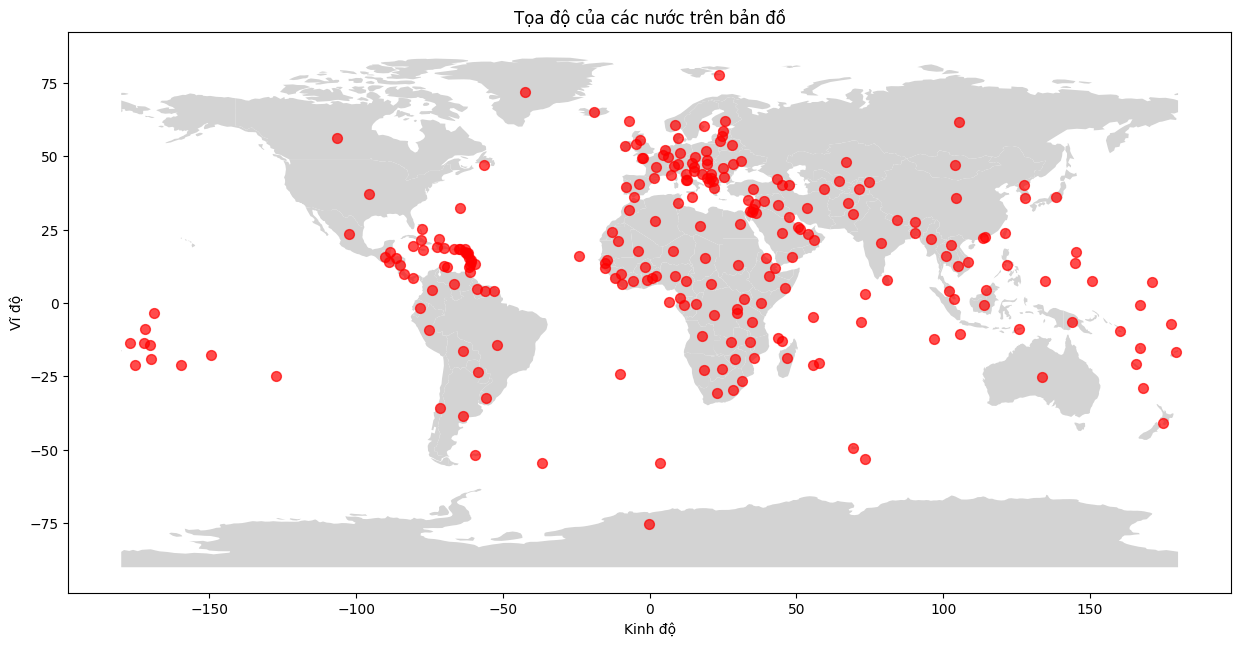

In [10]:
gdf = gpd.GeoDataFrame(df1, geometry = [Point(xy) for xy in zip(df1.longitude, df1.latitude)], crs = "EPSG:4326")

world = gpd.read_file('ne_110m_admin_0_countries')

fig, ax = plt.subplots(figsize=(15, 10))
world.plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax, color='red', markersize=50, alpha=0.7)

plt.title('Tọa độ của các nước trên bản đồ')
plt.xlabel('Kinh độ')
plt.ylabel('Vĩ độ')

plt.show()

2. Phân cụm theo 3 thuật toán K-Means, DBSCAN, và DPC

In [11]:
df2 = data.copy()

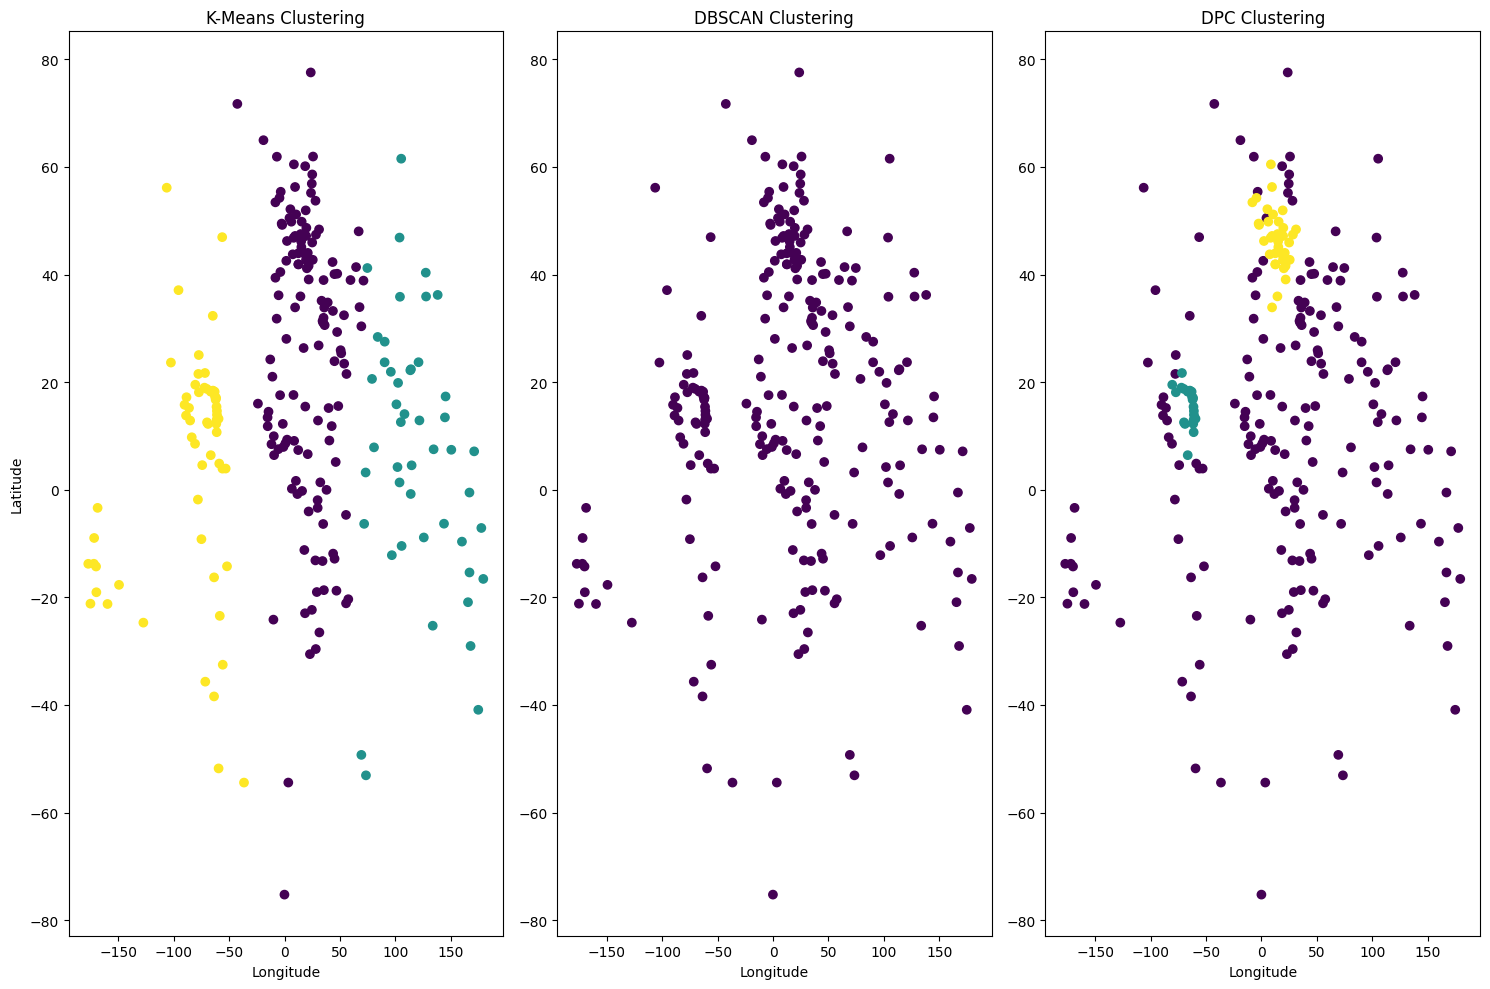

In [12]:
coordinates = df2[['latitude', 'longitude']]

imputer = SimpleImputer(strategy = 'mean')
coordinates_imputed = imputer.fit_transform(coordinates)

#K-MEANS
kmeans = KMeans(n_clusters = 3, random_state = 0)
df2['kmeans_cluster'] = kmeans.fit_predict(coordinates_imputed)

plt.figure(figsize=(15, 10))

plt.subplot(131)
plt.scatter(df2['longitude'], df2['latitude'], c = df2['kmeans_cluster'], cmap = 'viridis')
plt.title('K-Means Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

#DBSCAN
dbscan = DBSCAN(eps = 0.3, min_samples = 5)
df2['dbscan_cluster'] = dbscan.fit_predict(coordinates_imputed)

plt.subplot(132)
plt.scatter(df2['longitude'], df2['latitude'], c = df2['dbscan_cluster'], cmap = 'viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('Longitude')

#DPC

def calculate_local_density(dist_matrix, dc):
    N = dist_matrix.shape[0]
    densities = np.zeros(N)
    
    for i in range(N):
        densities[i] = np.sum(dist_matrix[i] < dc) - 1
    return densities

def calculate_min_distance(dist_matrix, densities):
    N = dist_matrix.shape[0]
    min_distances = np.full(N, np.inf)
    
    for i in range(N):
        for j in range(N):
            if densities[j] > densities[i]:
                if dist_matrix[i][j] < min_distances[i]:
                    min_distances[i] = dist_matrix[i][j]
    
    max_distance = np.max(dist_matrix)
    min_distances[min_distances == np.inf] = max_distance
    return min_distances

dist_matrix = squareform(pdist(coordinates_imputed))
dc = np.percentile(dist_matrix, 2)
densities = calculate_local_density(dist_matrix, dc)
min_distances = calculate_min_distance(dist_matrix, densities)

rho_threshold = np.percentile(densities, 90)
delta_threshold = np.percentile(min_distances, 90)

df2['dpc_cluster'] = -1
cluster_label = 0
for i in range(len(df2)):
    if densities[i] > rho_threshold and min_distances[i] > delta_threshold:
        df2.at[i, 'dpc_cluster'] = cluster_label
        cluster_label += 1

for i in range(len(df2)):
    if df2.at[i, 'dpc_cluster'] == -1:
        neighbors = np.where(dist_matrix[i] < dc)[0]
        neighbor_clusters = df2.loc[neighbors, 'dpc_cluster'].values
        if any(neighbor_clusters != -1):
            df2.at[i, 'dpc_cluster'] = neighbor_clusters[neighbor_clusters != -1][0]

plt.subplot(133)
plt.scatter(df2['longitude'], df2['latitude'], c = df2['dpc_cluster'], cmap = 'viridis')
plt.title('DPC Clustering')
plt.xlabel('Longitude')

plt.tight_layout()
plt.show()

3. So sánh kết quả và nhận xét

- Rõ ràng ta có thể thấy trong 3 loại thì K-means có khả năng phân cụm tốt nhất nhưng cũng gây khó khăn nhât